In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
pip install driverlessai

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade driverlessai

  Using cached driverlessai-2.2.3-py3-none-any.whl.metadata (9.1 kB)
Using cached driverlessai-2.2.3-py3-none-any.whl (2.4 MB)
  Attempting uninstall: driverlessai
    Found existing installation: driverlessai 1.11.1.1
    Uninstalling driverlessai-1.11.1.1:
      Successfully uninstalled driverlessai-1.11.1.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install h2o-authn~=1.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install h2o-engine-manager

Note: you may need to restart the kernel to use updated packages.


# 7+5 MODEL 12M

Visit https://2166999.dedicated.h2o.ai/auth/get-platform-token to get your platform token
Final model Score on RT Validation Data: 2.916


/tmp/ipykernel_1420/3499362200.py:41: UserWarning: 'Datasets.get_by_name' is a beta API that is subject to future changes.
  test_dai_model = dai.datasets.get_by_name(name="sugar11_dataset.csv")


Complete


/home/daviles/venv/lib/python3.12/site-packages/driverlessai/_experiments.py:2602: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")
/tmp/ipykernel_1420/3499362200.py:47: UserWarning: 'Datasets.get_by_name' is a beta API that is subject to future changes.
  test_dai_pred = dai.datasets.get_by_name(name="sugar11_predictions_12m.csv")


Complete


/home/daviles/venv/lib/python3.12/site-packages/driverlessai/_experiments.py:2602: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


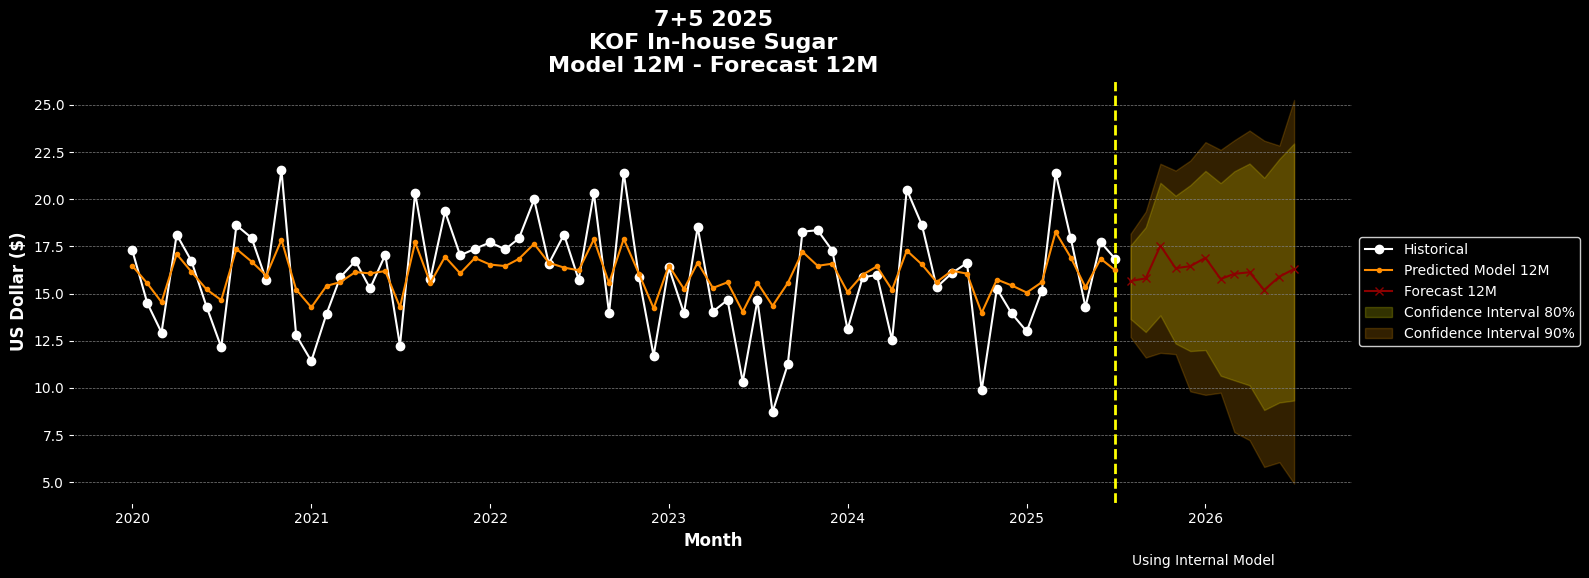

In [16]:
import h2o_authn 
import getpass 

print(f"Visit https://internal.dedicated.h2o.ai/auth/get-platform-token to get your platform token") 
token_provider = h2o_authn.TokenProvider(
  refresh_token='Insert Token',
  client_id="hac-platform-public", 
  token_endpoint_url="https://auth.internal.dedicated.h2o.ai/auth/realms/hac/protocol/openid-connect/token" 
)

import h2o_engine_manager 
aiem = h2o_engine_manager.login(
  environment="https://internal.dedicated.h2o.ai", 
  token_provider=token_provider
)

dai = aiem.dai_engine_client
engine = dai.get_engine(
        workspace_id= 'default',
        engine_id= 'sugar11' 
    )

dai = engine.connect()

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats



#exalum12m = dai.experiments.get('effc01c2-0107-11f0-8ecd-6aac8c934113')
#metrics = exalum12m.metrics()
#print("Final model Score on Validation Data: " + str(round(metrics['val_score'], 4)))
rtexpetrr12m = dai.experiments.get('73839f66-89eb-11f0-a758-1aad0e6cea2c')
metrics = rtexpetrr12m .metrics()
print("Final model Score on RT Validation Data: " + str(round(metrics['val_score'], 4)))

#Model Pattern with retrain
test_dai_model = dai.datasets.get_by_name(name="sugar11_dataset.csv")
model12m_predictions  = rtexpetrr12m.predict( dataset=test_dai_model).to_pandas()
model12m_predictions= model12m_predictions[['Sugar11']]
model12m_predictions.rename(columns={'Sugar11': 'Sugar_price_model_12m'}, inplace = True)

#Forecast predicions with retrain
test_dai_pred = dai.datasets.get_by_name(name="sugar11_predictions_12m.csv")
f12m_predictions = rtexpetrr12m.predict( dataset=test_dai_pred).to_pandas()
f12m_predictions.rename(columns={'Sugar11': 'Sugar_price_forecast_12m'}, inplace = True)
df_test = pd.read_csv('sugar11_predictions_12m.csv')
df_test=df_test[['Month']]
df_f12m = pd.concat([df_test,f12m_predictions],axis=1)
dfactual = pd.read_csv('sugar11_dataset.csv')
dfactual =dfactual[['Month','Sugar11']]
dfactual.rename(columns={'Sugar11': 'Sugar_price_actual'}, inplace = True)
df_actual_model = pd.concat([dfactual,model12m_predictions],axis=1)
df_final_f12m = pd.merge(df_actual_model,df_f12m, on=['Month'], how='outer') 

df = pd.DataFrame(df_final_f12m)
df['Month'] = pd.to_datetime(df['Month'])
df = df[df["Month"] >= "2020-01-01"].copy()

# Calcular errores históricos
df['Error'] = df['Sugar_price_actual'] - df['Sugar_price_model_12m']
historical_std_error = df['Error'].std()

# Configuración para simulaciones
num_simulations = 1000  # Número de simulaciones
forecast_horizon = len(df[df['Sugar_price_forecast_12m'].notnull()])  # Horizonte de pronóstico

# Simular errores históricos (muestreo con reemplazo)
simulated_errors = np.random.choice(df['Error'].dropna(), size=(num_simulations, forecast_horizon), replace=True)

# Introducir el efecto del tiempo con escalamiento por raíz del tiempo
time_effect = np.sqrt(np.arange(1, forecast_horizon + 1))  # Escalamiento por raíz del tiempo
scaled_errors = simulated_errors * time_effect  # Ajustar errores según el horizonte
scaled_errors *= 0.8  # Reducir la amplitud general de los intervalos


# Introducir el efecto del tiempo con escalamiento ajustado
#time_effect = np.log(np.arange(1, forecast_horizon + 1) + 1)  # Escalamiento logarítmico
#scaled_errors = simulated_errors * time_effect  # Escalar errores según el horizonte
#scaled_errors *= 0.8  # Reducir la amplitud general de los intervalos

# Calcular los percentiles para intervalos de confianza al 80% y 90%
confidence_levels = [0.80, 0.90]
percentiles = [(1 - cl) / 2 * 100 for cl in confidence_levels] + [(1 + cl) / 2 * 100 for cl in confidence_levels]

# Calcular los límites inferiores y superiores para cada nivel de confianza
bounds = np.percentile(scaled_errors, percentiles, axis=0)

# Ajustar a las predicciones del modelo
forecast_data = df[df['Sugar_price_forecast_12m'].notnull()].copy()
for i, cl in enumerate(confidence_levels):
    forecast_data[f'Lower_CI_{int(cl*100)}'] = forecast_data['Sugar_price_forecast_12m'].values + bounds[i]
    forecast_data[f'Upper_CI_{int(cl*100)}'] = forecast_data['Sugar_price_forecast_12m'].values + bounds[i + len(confidence_levels)]


# Crear la figura con fondo negro
fig, ax = plt.subplots(figsize=(16, 6), facecolor='black')  # Fondo negro para la figura

# Establecer el fondo negro para los ejes
ax.set_facecolor('black')  # Fondo negro para el área dentro de los ejes

# Graficar los datos históricos
historical_data = df[df['Sugar_price_actual'].notnull()]
plt.plot(historical_data['Month'], historical_data['Sugar_price_actual'], 
         label='Historical', color='white', marker='o')
plt.plot(historical_data['Month'], historical_data['Sugar_price_model_12m'], 
         label='Predicted Model 12M', color='darkorange', linestyle='-', marker='.')

# Graficar los pronósticos
plt.plot(forecast_data['Month'], forecast_data['Sugar_price_forecast_12m'], 
         label='Forecast 12M', color='darkred', marker='x')

# Graficar los intervalos de confianza al 80% y 90%


colors = {
    80: 'yellow',  # Color para el intervalo del 80%
    90: 'orange' # Color para el intervalo del 90%
}

for cl in confidence_levels:
    plt.fill_between(forecast_data['Month'], 
                     forecast_data[f'Lower_CI_{int(cl*100)}'], 
                     forecast_data[f'Upper_CI_{int(cl*100)}'], 
                     alpha=0.2,color=colors[int(cl*100)]
                     , label=f'Confidence Interval {int(cl*100)}%')

# Configuración de la gráfica
ax.set_title("7+5 2025\nKOF In-house Sugar\nModel 12M - Forecast 12M", fontsize=16, fontweight="bold", color='white', loc='center')
ax.set_xlabel('Month', fontsize=12, fontweight="bold", color='white')
ax.set_ylabel("US Dollar ($)", fontsize=12, fontweight="bold", color='white')
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=pd.to_datetime("2025-07-01"), color="yellow", linestyle="--", linewidth=2)

# Configuración de la leyenda
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')  # Texto de la leyenda en blanco

# Configurar los ticks de los ejes en blanco
plt.tick_params(axis='x', colors='white')  # Eje X en blanco
plt.tick_params(axis='y', colors='white')  # Eje Y en blanco


# Texto adicional
fig.text(0.8, 0.05, "Using Internal Model", fontsize=10, ha="right", color="white")

# Ajuste de diseño
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Mostrar la gráfica
plt.show()


Visit https://2166999.dedicated.h2o.ai/auth/get-platform-token to get your platform token
Final model Score on RT Validation Data: 2.916


/tmp/ipykernel_1420/1371527658.py:41: UserWarning: 'Datasets.get_by_name' is a beta API that is subject to future changes.
  test_dai_model = dai.datasets.get_by_name(name="sugar11_dataset.csv")


Complete


/home/daviles/venv/lib/python3.12/site-packages/driverlessai/_experiments.py:2602: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")
/tmp/ipykernel_1420/1371527658.py:47: UserWarning: 'Datasets.get_by_name' is a beta API that is subject to future changes.
  test_dai_pred = dai.datasets.get_by_name(name="sugar11_predictions_12m.csv")


Complete


/home/daviles/venv/lib/python3.12/site-packages/driverlessai/_experiments.py:2602: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


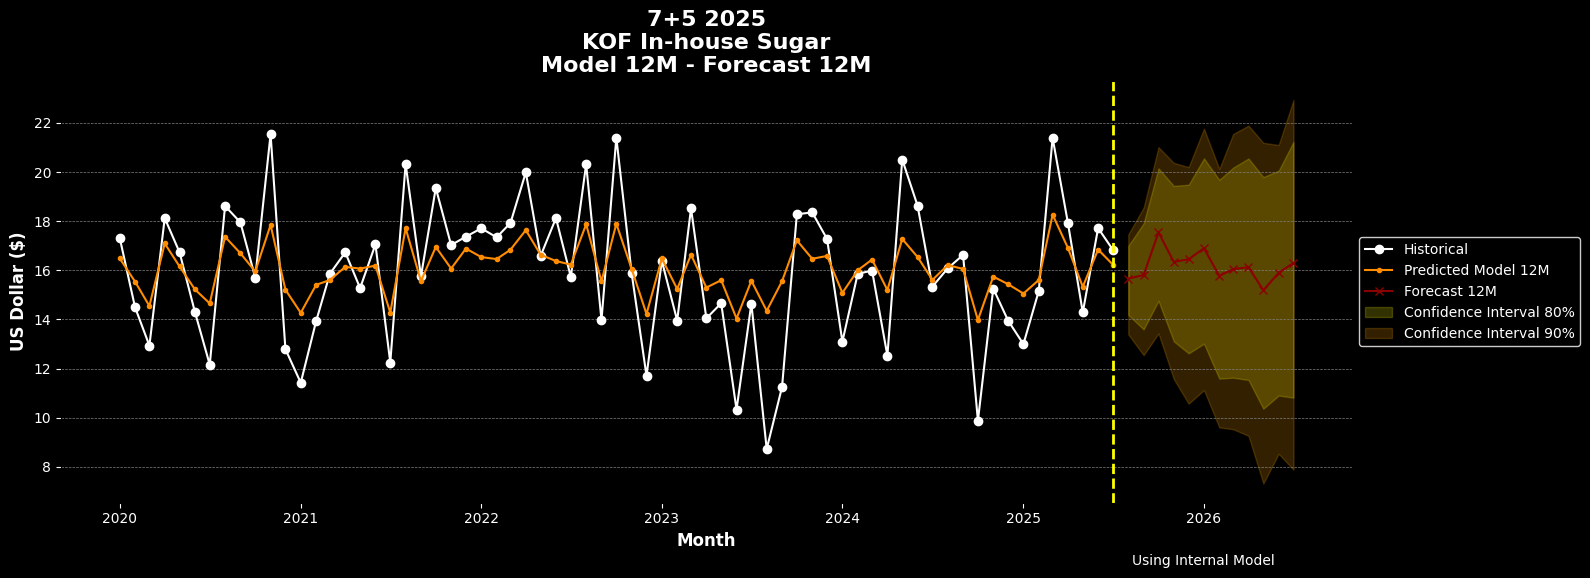

In [17]:
import h2o_authn 
import getpass 

print(f"Visit https://internal.dedicated.h2o.ai/auth/get-platform-token to get your platform token") 
token_provider = h2o_authn.TokenProvider(
  refresh_token='insert token',
  client_id="hac-platform-public", 
  token_endpoint_url="https://auth.internal.dedicated.h2o.ai/auth/realms/hac/protocol/openid-connect/token" 
)

import h2o_engine_manager 
aiem = h2o_engine_manager.login(
  environment="https://internal.dedicated.h2o.ai", 
  token_provider=token_provider
)

dai = aiem.dai_engine_client
engine = dai.get_engine(
        workspace_id= 'default',
        engine_id= 'sugar11' 
    )

dai = engine.connect()

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats



#exalum12m = dai.experiments.get('effc01c2-0107-11f0-8ecd-6aac8c934113')
#metrics = exalum12m.metrics()
#print("Final model Score on Validation Data: " + str(round(metrics['val_score'], 4)))
rtexpetrr12m = dai.experiments.get('73839f66-89eb-11f0-a758-1aad0e6cea2c')
metrics = rtexpetrr12m .metrics()
print("Final model Score on RT Validation Data: " + str(round(metrics['val_score'], 4)))

#Model Pattern with retrain
test_dai_model = dai.datasets.get_by_name(name="sugar11_dataset.csv")
model12m_predictions  = rtexpetrr12m.predict( dataset=test_dai_model).to_pandas()
model12m_predictions= model12m_predictions[['Sugar11']]
model12m_predictions.rename(columns={'Sugar11': 'Sugar_price_model_12m'}, inplace = True)

#Forecast predicions with retrain
test_dai_pred = dai.datasets.get_by_name(name="sugar11_predictions_12m.csv")
f12m_predictions = rtexpetrr12m.predict( dataset=test_dai_pred).to_pandas()
f12m_predictions.rename(columns={'Sugar11': 'Sugar_price_forecast_12m'}, inplace = True)
df_test = pd.read_csv('sugar11_predictions_12m.csv')
df_test=df_test[['Month']]
df_f12m = pd.concat([df_test,f12m_predictions],axis=1)
dfactual = pd.read_csv('sugar11_dataset.csv')
dfactual =dfactual[['Month','Sugar11']]
dfactual.rename(columns={'Sugar11': 'Sugar_price_actual'}, inplace = True)
df_actual_model = pd.concat([dfactual,model12m_predictions],axis=1)
df_final_f12m = pd.merge(df_actual_model,df_f12m, on=['Month'], how='outer') 

df = pd.DataFrame(df_final_f12m)
df['Month'] = pd.to_datetime(df['Month'])
df = df[df["Month"] >= "2020-01-01"].copy()

# Calcular errores históricos
df['Error'] = df['Sugar_price_actual'] - df['Sugar_price_model_12m']
historical_std_error = df['Error'].std()

# Configuración para simulaciones
num_simulations = 1000  # Número de simulaciones
forecast_horizon = len(df[df['Sugar_price_forecast_12m'].notnull()])  # Horizonte de pronóstico

# Simular errores históricos (muestreo con reemplazo)
simulated_errors = np.random.choice(df['Error'].dropna(), size=(num_simulations, forecast_horizon), replace=True)

# Introducir el efecto del tiempo con escalamiento por raíz del tiempo
#time_effect = np.sqrt(np.arange(1, forecast_horizon + 1))  # Escalamiento por raíz del tiempo
#scaled_errors = simulated_errors * time_effect  # Ajustar errores según el horizonte
#scaled_errors *= 0.8  # Reducir la amplitud general de los intervalos


# Introducir el efecto del tiempo con escalamiento ajustado
time_effect = np.log(np.arange(1, forecast_horizon + 1) + 1)  # Escalamiento logarítmico
scaled_errors = simulated_errors * time_effect  # Escalar errores según el horizonte
scaled_errors *= 0.8  # Reducir la amplitud general de los intervalos

# Calcular los percentiles para intervalos de confianza al 80% y 90%
confidence_levels = [0.80, 0.90]
percentiles = [(1 - cl) / 2 * 100 for cl in confidence_levels] + [(1 + cl) / 2 * 100 for cl in confidence_levels]

# Calcular los límites inferiores y superiores para cada nivel de confianza
bounds = np.percentile(scaled_errors, percentiles, axis=0)

# Ajustar a las predicciones del modelo
forecast_data = df[df['Sugar_price_forecast_12m'].notnull()].copy()
for i, cl in enumerate(confidence_levels):
    forecast_data[f'Lower_CI_{int(cl*100)}'] = forecast_data['Sugar_price_forecast_12m'].values + bounds[i]
    forecast_data[f'Upper_CI_{int(cl*100)}'] = forecast_data['Sugar_price_forecast_12m'].values + bounds[i + len(confidence_levels)]


# Crear la figura con fondo negro
fig, ax = plt.subplots(figsize=(16, 6), facecolor='black')  # Fondo negro para la figura

# Establecer el fondo negro para los ejes
ax.set_facecolor('black')  # Fondo negro para el área dentro de los ejes

# Graficar los datos históricos
historical_data = df[df['Sugar_price_actual'].notnull()]
plt.plot(historical_data['Month'], historical_data['Sugar_price_actual'], 
         label='Historical', color='white', marker='o')
plt.plot(historical_data['Month'], historical_data['Sugar_price_model_12m'], 
         label='Predicted Model 12M', color='darkorange', linestyle='-', marker='.')

# Graficar los pronósticos
plt.plot(forecast_data['Month'], forecast_data['Sugar_price_forecast_12m'], 
         label='Forecast 12M', color='darkred', marker='x')

# Graficar los intervalos de confianza al 80% y 90%


colors = {
    80: 'yellow',  # Color para el intervalo del 80%
    90: 'orange' # Color para el intervalo del 90%
}

for cl in confidence_levels:
    plt.fill_between(forecast_data['Month'], 
                     forecast_data[f'Lower_CI_{int(cl*100)}'], 
                     forecast_data[f'Upper_CI_{int(cl*100)}'], 
                     alpha=0.2,color=colors[int(cl*100)]
                     , label=f'Confidence Interval {int(cl*100)}%')

# Configuración de la gráfica
ax.set_title("7+5 2025\nKOF In-house Sugar\nModel 12M - Forecast 12M", fontsize=16, fontweight="bold", color='white', loc='center')
ax.set_xlabel('Month', fontsize=12, fontweight="bold", color='white')
ax.set_ylabel("US Dollar ($)", fontsize=12, fontweight="bold", color='white')
ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=pd.to_datetime("2025-07-01"), color="yellow", linestyle="--", linewidth=2)

# Configuración de la leyenda
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), facecolor='black', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')  # Texto de la leyenda en blanco

# Configurar los ticks de los ejes en blanco
plt.tick_params(axis='x', colors='white')  # Eje X en blanco
plt.tick_params(axis='y', colors='white')  # Eje Y en blanco


# Texto adicional
fig.text(0.8, 0.05, "Using Internal Model", fontsize=10, ha="right", color="white")

# Ajuste de diseño
plt.tight_layout(rect=[0, 0.05, 1, 1])

# Mostrar la gráfica
plt.show()
